In [1]:
import os, sys, re, math, random, gc
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_columns', 80)
pd.set_option('display.width', 160)

def try_import(name, import_name=None):
    try:
        if import_name:
            module = __import__(import_name, fromlist=[name])
        else:
            module = __import__(name)
        return module, None
    except Exception as e:
        return None, e

torch, err_torch = try_import("torch", "torch")
pyg, err_pyg = try_import("torch_geometric", "torch_geometric")
if torch is None or pyg is None:
    display(Markdown("**Note:** `torch` or `torch_geometric` not detected. You can still run the NetworkX-based EDA. If you want PyG for modeling, install compatible torch + torch_geometric (see PyG docs)."))


**Note:** `torch` or `torch_geometric` not detected. You can still run the NetworkX-based EDA. If you want PyG for modeling, install compatible torch + torch_geometric (see PyG docs).

In [22]:
# Cell 2: set path and load CSV (adjust csv_path to match your environment)
csv_path = "../DrugBank_data/drugbank.csv"   # <-- update this path if your file is elsewhere

if not os.path.exists(csv_path):
    display(Markdown(f"**CSV not found at `{csv_path}`.** Please update `csv_path` to the correct location and re-run this cell."))
else:
    # load a small head first
    display(Markdown("### Preview (first 500 rows)"))
    display(pd.read_csv(csv_path, nrows=5).head())

    # now load everything as strings (safer for IDs)
    df = pd.read_csv(csv_path, dtype=str, low_memory=False)
    display(Markdown(f"Loaded dataframe shape: **{df.shape}**"))
    display(df.columns.tolist())


### Preview (first 500 rows)

,type,created,updated,drugbank-id,name,description,cas-number,unii,state,groups,synthesis-reference,indication,pharmacodynamics,mechanism-of-action,toxicity,metabolism,absorption,half-life,protein-binding,route-of-elimination,volume-of-distribution,clearance,atc-codes,ahfs-codes,pdb-entries,food-interactions,drug-interactions,sequences,enzymes,pathways,reactions,snp-effects,snp-adverse-drug-reactions,targets,carriers,transporters,fda-label,msds,average-mass,monoisotopic-mass
0,biotech,2005-06-13,2023-01-03,DB00001,Lepirudin,"Lepirudin is a recombinant hirudin formed by 65 amino acids that acts as a highly specific and direct thrombin inhibitor.[L41539,L41569] Natural hirudin is an endogenous anticoagulant found in _Hirudo medicinalis_ leeches.[L41539] Lepirudin is produced in yeast cells and is identical to natural hirudin except for the absence of sulfate on the tyrosine residue at position 63 and the substitutio...",138068-37-8,Y43GF64R34,solid,approved withdrawn,"Recombinant hirudin expressed by using yeast secretary (China Patent No. CN1371994A, 2001). China National Intellectual Property Administration. https://patents.google.com/patent/CN1371994A/en","Lepirudin is indicated for anticoagulation in adult patients with acute coronary syndromes (ACS) such as unstable angina and acute myocardial infarction without ST elevation. In patients with ACS, lepirudin is intended for use with [aspirin].[L41539] Lepirudin is also indicated for anticoagulation in patients with heparin-induced thrombocytopenia (HIT) and associated thromboembolic disease in ...","Lepirudin is a recombinant hirudin that acts as a highly specific thrombin inhibitor. Its activity is measured by anti-thrombin units (ATUs) that correspond to the amount of lepirudin required to neutralize a unit of the World Health Organization α-thrombin (89/588) standard. The activity of lepirudin is 16,000 ATU/mg.[L41539,L41569] A single molecule of lepirudin binds to a molecule of thromb...","Lepirudin is a direct thrombin inhibitor used as an anticoagulant in patients for whom heparin is contraindicated.[L41539,A3] Thrombin is a serine protease that participates in the blood-clotting cascade, and it is formed by the cleavage of pro-thrombin. Active thrombin cleaves fibrinogen and generates fibrin monomers that polymerize to form fibrin clots.[A246624]\n\nLepirudin binds to the cat...","The acute toxicity of intravenous lepirudin was evaluated in mice (0.1-1000 mg/kg), rats (1-1000 mg/kg), and monkeys (1-100 mg/kg), and toxicity was not detected at the doses investigated.[L41539] The acute toxicity of lepirudin administered subcutaneously was also evaluated in mice (1-1250 mg/kg) and rats (1-500 mg/kg), and no toxicity was detected.[L41539] One rat (100 mg/kg) died of rapid b...","As a polypeptide, lepirudin is expected to be metabolized by the sequential cleavage of amino acids by kidney exoproteases, which have carboxypeptidase and dipeptidase-like activity.[L41539,L41544] The C-terminal cleavage of lepirudin aminoacids (aminoacids 1 to 65) produces four metabolites with anti-thrombotic activity: M1 (aminoacids 1 to 64), M2 (aminoacids 1 to 63), M3 (aminoacids 1 to 62...","Lepirudin administered as a single intravenous bolus injection of 0.4 mg/kg in 9 healthy volunteers (male and female) resulted in a C<sub>max</sub> of 2924 ng/mL, a t<sub>max</sub> of 0.17 h and an AUC<sub>0-∞</sub> of 2500 ng•h/mL.[L41539] When 0.1, 0.15 and 0.2 mg/kg of lepirudin was administered as a single intravenous infusion over 6 hours in healthy male volunteers, lepirudin had a corres...","Lepirudin has an initial half-life of approximately 10 minutes, and in young healthy volunteers, it has a terminal half-time of 1.3 hours.[L41539] Lepirudin has a first-order elimination kinetic; plasma concentration increases proportionally as the lepirudin intravenous dose is increased. Elimination half-life values of up to 2 days were detected in patients with marked renal insufficiency (cr...","In human p

Loaded dataframe shape: **(16762, 40)**

['type',
 'created',
 'updated',
 'drugbank-id',
 'name',
 'description',
 'cas-number',
 'unii',
 'state',
 'groups',
 'synthesis-reference',
 'indication',
 'pharmacodynamics',
 'mechanism-of-action',
 'toxicity',
 'metabolism',
 'absorption',
 'half-life',
 'protein-binding',
 'route-of-elimination',
 'volume-of-distribution',
 'clearance',
 'atc-codes',
 'ahfs-codes',
 'pdb-entries',
 'food-interactions',
 'drug-interactions',
 'sequences',
 'enzymes',
 'pathways',
 'reactions',
 'snp-effects',
 'snp-adverse-drug-reactions',
 'targets',
 'carriers',
 'transporters',
 'fda-label',
 'msds',
 'average-mass',
 'monoisotopic-mass']

In [ ]:
# Cell 3: missingness and unique counts
if 'df' in globals():
    missing_pct = df.isna().mean() * 100
    info = pd.DataFrame({
        "column": df.columns,
        "missing_pct": missing_pct.values,
        "n_unique": [df[c].nunique(dropna=True) for c in df.columns]
    }).sort_values("missing_pct")
    display(Markdown("### Missingness % and unique counts"))
    display(info.head(80))
    display(Markdown("### Top 20 columns by coverage"))
    display((100-info['missing_pct']).sort_values(ascending=False).head(20))


### Missingness % and unique counts

,column,missing_pct,n_unique
3,drugbank-id,3.555662,15235
4,name,3.555662,15235
1,created,9.109891,760
0,type,9.109891,2
2,updated,9.109891,274
9,groups,9.109891,50
5,description,22.867200,8791
38,average-mass,30.879370,9972
39,monoisotopic-mass,30.879370,10030
7,unii,34.769121,10934


### Top 20 columns by coverage

3     96.444338
4     96.444338
1     90.890109
0     90.890109
2     90.890109
9     90.890109
5     77.132800
38    69.120630
39    69.120630
7     65.230879
6     56.992006
8     54.713041
33    46.933540
24    35.437299
26    26.715189
11    24.901563
13    23.344470
22    20.301873
12    18.148192
14    14.509008
Name: missing_pct, dtype: float64

In [5]:
# Cell 4: parsing helper
if 'df' in globals():
    def parse_id_list(cell):
        if pd.isna(cell):
            return []
        s = str(cell).strip()
        if s == "[]":
            return []
        tokens = re.split(r'[\s;,\|]+', s)
        tokens = [t.strip() for t in tokens if t.strip()!='' and t.strip()!="nan"]
        return tokens

    cols_interest = ["drugbank-id","name","targets","enzymes","transporters","carriers","pathways",
                     "reactions","snp-effects","snp-adverse-drug-reactions","drug-interactions",
                     "atc-codes","mechanism-of-action","description","half-life","protein-binding",
                     "average-mass","monoisotopic-mass","groups"]
    cols_present = [c for c in cols_interest if c in df.columns]
    display(Markdown(f"Columns present from interest list: {cols_present}"))

    sample = df[cols_present].head(20).copy()
    for col in ["targets","enzymes","transporters","pathways","reactions","snp-effects","drug-interactions"]:
        if col in sample:
            sample[col] = sample[col].apply(parse_id_list)
    display(Markdown("Sample parsed rows"))
    display(sample.head(20))


Columns present from interest list: ['drugbank-id', 'name', 'targets', 'enzymes', 'transporters', 'carriers', 'pathways', 'reactions', 'snp-effects', 'snp-adverse-drug-reactions', 'drug-interactions', 'atc-codes', 'mechanism-of-action', 'description', 'half-life', 'protein-binding', 'average-mass', 'monoisotopic-mass', 'groups']

Sample parsed rows

,drugbank-id,name,targets,enzymes,transporters,carriers,pathways,reactions,snp-effects,snp-adverse-drug-reactions,drug-interactions,atc-codes,mechanism-of-action,description,half-life,protein-binding,average-mass,monoisotopic-mass,groups
0,DB00001,Lepirudin,[],[],[],NaN,[],[],[],NaN,"[DB13821, DB00328, DB08953, DB00682, DB00928, DB09124, DB13400, DB09381, DB00656, DB09052, DB06679, DB06737, DB03374, DB08814, DB12289, DB06251, DB09217, DB11133, DB00970, DB01066, DB13875, DB13876, DB00034, DB00814, DB00562, DB00036, DB09253, DB01247, DB14006, DB01942, DB00642, DB13510, DB13286, DB00495, DB00232, DB13432, DB13199, DB00105, DB06228, DB13947, DB00305, DB00605, DB00957, DB06715,...",BLOOD AND BLOOD FORMING ORGANS ANTITHROMBOTIC AGENTS Direct thrombin inhibitors,"Lepirudin is a direct thrombin inhibitor used as an anticoagulant in patients for whom heparin is contraindicated.[L41539,A3] Thrombin is a serine protease that participates in the blood-clotting cascade, and it is formed by the cleavage of pro-thrombin. Active thrombin cleaves fibrinogen and generates fibrin monomers that polymerize to form fibrin clots.[A246624]\n\nLepirudin binds to the cat...","Lepirudin is a recombinant hirudin formed by 65 amino acids that acts as a highly specific and direct thrombin inhibitor.[L41539,L41569] Natural hirudin is an endogenous anticoagulant found in _Hirudo medicinalis_ leeches.[L41539] Lepirudin is produced in yeast cells and is identical to natural hirudin except for the absence of sulfate on the tyrosine residue at position 63 and the substitutio...","Lepirudin has an initial half-life of approximately 10 minutes, and in young healthy volunteers, it has a terminal half-time of 1.3 hours.[L41539] Lepirudin has a first-order elimination kinetic; plasma concentration increases proportionally as the lepirudin intravenous dose is increased. Elimination half-life values of up to 2 days were detected in patients with marked renal insufficiency (cr...","In human plasma, the protein binding of lepirudin was approximately 3%.[L41539]",NaN,NaN,approved withdrawn
1,NaN,NaN,[],[],[],NaN,[],[],[],NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,[BE0000048],[],[],NaN,"[P00488, P00748, P38435, Q9BQB6, P00734, P08709, P03952, P00451, P13726, P00742, P03951, P00740, P00747, P02671, P05160, P02679, P02452, P02675, P00750, P12259]",[],[],NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DB00002,Cetuximab,[],[],[],NaN,[],[],[],NaN,"[DB05209, DB14905, DB06474, DB09381, DB06647, DB11959, DB09052, DB13259, DB12034, DB11857, DB14039, DB12023, DB06305, DB15898, DB14877, DB00814, DB11604, DB12344, DB13886, DB05232, DB14811, DB11884, DB11685, DB11746, DB15118, DB01086, DB14997, DB12815, DB12235, DB06602, DB12053, DB14012, DB09035, DB14891, DB13017, DB01075, DB00108, DB06599, DB06310, DB14864, DB09105, DB12520, DB12396, DB05797,...",ANTINEOPLASTIC AND IMMUNOMODULATING AGENTS MONOCLONAL ANTIBODIES AND ANTIBODY DRUG CONJUGATES ANTINEOPLASTIC AGENTS EGFR (Epidermal Growth Factor Receptor) inhibitors,"The epidermal growth factor receptor (EGFR) is a transmembrane glycoprotein and a type I receptor tyrosine kinase expressed on both normal and malignant cells. It has been investigated as a therapeutic target for anticancer treatment, as it is often upregulated in cancer types, including head and neck, colon, and rectal cancers.[L30448] When activated by its ligand, EGFR undergoes a conformati...",Cetuximab is a recombinant chimeric human/mouse IgG1 monoclonal antibody that competitively binds to epidermal growth factor receptor (EGFR) and competitively inhibits the binding of epidermal growth factor (EGF).[A227973] EGFR is a member of the ErbB family of receptor tyrosine kinases found in both normal and tumour cells; it is responsible for regulating epithelial tissue development and ho...,"After administration of a 400 mg/m<sup>2</sup> initial dose followed by a 250 mg/m<sup>2</sup> weekly dose, the mean half-life for cetuximab was approximately 112 hours, with a range of 63 t

In [6]:
# Cell 5: build drug -> entity mappings
if 'df' in globals():
    drug_id_col = "drugbank-id" if "drugbank-id" in df.columns else "name"
    display(Markdown(f"Using canonical id column: **{drug_id_col}**"))

    drug_to_targets = {}
    drug_to_enzymes = {}
    drug_to_transporters = {}
    drug_to_pathways = {}
    drug_to_reactions = {}
    drug_to_snps = {}
    drug_to_interactions = {}

    for idx, row in df.iterrows():
        did = row.get(drug_id_col)
        if pd.isna(did): 
            continue
        did = str(did).strip()
        def get_list(col):
            return parse_id_list(row.get(col)) if col in df.columns else []
        drug_to_targets.setdefault(did, []).extend(get_list("targets"))
        drug_to_enzymes.setdefault(did, []).extend(get_list("enzymes"))
        drug_to_transporters.setdefault(did, []).extend(get_list("transporters"))
        drug_to_pathways.setdefault(did, []).extend(get_list("pathways"))
        drug_to_reactions.setdefault(did, []).extend(get_list("reactions"))
        drug_to_snps.setdefault(did, []).extend(get_list("snp-effects"))
        # naive extraction for drug-interactions (DB or BE tokens)
        if "drug-interactions" in df.columns:
            cell = row.get("drug-interactions")
            if not pd.isna(cell):
                raw_tokens = re.split(r'[\s;,\|]+', str(cell))
                parsed = [t for t in raw_tokens if re.match(r'^(BE|DB)\w+', t)]
            else:
                parsed = []
            drug_to_interactions.setdefault(did, []).extend(parsed)

    def uniq(d): return {k: list(dict.fromkeys(v)) for k,v in d.items()}
    drug_to_targets = uniq(drug_to_targets)
    drug_to_enzymes = uniq(drug_to_enzymes)
    drug_to_transporters = uniq(drug_to_transporters)
    drug_to_pathways = uniq(drug_to_pathways)
    drug_to_reactions = uniq(drug_to_reactions)
    drug_to_snps = uniq(drug_to_snps)
    drug_to_interactions = uniq(drug_to_interactions)

    display(Markdown("Mappings built. Quick counts:"))
    display(pd.DataFrame({
        "drugs_total": [len(set(df[drug_id_col].dropna()))],
        "drugs_with_targets": [sum(1 for k,v in drug_to_targets.items() if v)],
        "drugs_with_enzymes": [sum(1 for k,v in drug_to_enzymes.items() if v)],
        "drugs_with_transporters": [sum(1 for k,v in drug_to_transporters.items() if v)],
        "drugs_with_interactions": [sum(1 for k,v in drug_to_interactions.items() if v)]
    }))


Using canonical id column: **drugbank-id**

Mappings built. Quick counts:

,drugs_total,drugs_with_targets,drugs_with_enzymes,drugs_with_transporters,drugs_with_interactions
0,15235,7296,1541,804,4478


In [7]:
# Cell 6: top protein frequencies
if 'df' in globals():
    counter = Counter()
    for v in drug_to_targets.values(): counter.update(v)
    for v in drug_to_enzymes.values(): counter.update(v)
    for v in drug_to_transporters.values(): counter.update(v)
    top = pd.DataFrame(counter.most_common(40), columns=["protein_id","count"])
    display(Markdown("Top proteins by frequency"))
    display(top.head(20))


Top proteins by frequency

,protein_id,count
0,BE0002638,835
1,BE0001032,463
2,BE0002363,301
3,BE0002433,293
4,BE0002793,291
5,BE0003536,249
6,BE0002887,226
7,BE0002362,212
8,BE0001067,193
9,BE0003549,160


In [15]:
# Cell 7 — Build Heterogeneous Graph Using PyTorch Geometric 
from torch_geometric.data import HeteroData
import torch

display(Markdown("## Building Heterogeneous Graph with PyTorch Geometric"))

# 1. Build node index dictionaries
drug_ids = sorted(list(set(df[drug_id_col].dropna())))
protein_ids = set()

# Collect all protein-like IDs (targets, enzymes, transporters)
for did in drug_ids:
    protein_ids.update(drug_to_targets.get(did, []))
    protein_ids.update(drug_to_enzymes.get(did, []))
    protein_ids.update(drug_to_transporters.get(did, []))

protein_ids = sorted(list(protein_ids))

# Build index maps
drug_index = {d: i for i, d in enumerate(drug_ids)}
protein_index = {p: i for i, p in enumerate(protein_ids)}

display(Markdown(f"Total drug nodes: **{len(drug_index)}**"))
display(Markdown(f"Total protein nodes: **{len(protein_index)}**"))

# 2. Create PyG HeteroData object
data = HeteroData()

# add node counts
data['drug'].num_nodes = len(drug_index)
data['protein'].num_nodes = len(protein_index)


# 3. Add drug→protein edges for each relation type
def make_edge_tensor(edge_list):
    if len(edge_list) == 0:
        return torch.empty((2,0), dtype=torch.long)
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    return edge_index

# build relation edges separately
drug_target_edges = []
drug_enzyme_edges = []
drug_transporter_edges = []

for did in drug_ids:
    u = drug_index[did]
    # targets
    for prot in drug_to_targets.get(did, []):
        if prot in protein_index:
            drug_target_edges.append([u, protein_index[prot]])
    # enzymes
    for prot in drug_to_enzymes.get(did, []):
        if prot in protein_index:
            drug_enzyme_edges.append([u, protein_index[prot]])
    # transporters
    for prot in drug_to_transporters.get(did, []):
        if prot in protein_index:
            drug_transporter_edges.append([u, protein_index[prot]])

data['drug', 'targets', 'protein'].edge_index = make_edge_tensor(drug_target_edges)
data['drug', 'enzymes', 'protein'].edge_index = make_edge_tensor(drug_enzyme_edges)
data['drug', 'transporters', 'protein'].edge_index = make_edge_tensor(drug_transporter_edges)

display(Markdown(f"Target edges: **{len(drug_target_edges)}**"))
display(Markdown(f"Enzyme edges: **{len(drug_enzyme_edges)}**"))
display(Markdown(f"Transporter edges: **{len(drug_transporter_edges)}**"))


# 4. Add drug↔drug interactions (DDI links)
ddi_edges = []
for a, lst in drug_to_interactions.items():
    if a in drug_index:
        for b in lst:
            if b in drug_index:
                # undirected → save one direction
                u, v = drug_index[a], drug_index[b]
                if u != v:
                    ddi_edges.append([u, v])

data['drug', 'interacts', 'drug'].edge_index = make_edge_tensor(ddi_edges)
display(Markdown(f"DDI edges: **{len(ddi_edges)}**"))

print(data)


c:\Users\anujm\anaconda3\envs\DDI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Building Heterogeneous Graph with PyTorch Geometric

Total drug nodes: **15235**

Total protein nodes: **5528**

Target edges: **16040**

Enzyme edges: **10386**

Transporter edges: **2354**

DDI edges: **2866522**

HeteroData(
  drug={ num_nodes=15235 },
  protein={ num_nodes=5528 },
  (drug, targets, protein)={ edge_index=[2, 16040] },
  (drug, enzymes, protein)={ edge_index=[2, 10386] },
  (drug, transporters, protein)={ edge_index=[2, 2354] },
  (drug, interacts, drug)={ edge_index=[2, 2866522] }
)


## Basic Graph Statistics (PyG)

### Drug Node Degree Stats

,min_degree,max_degree,mean_degree,median_degree
0,0,2535,190.042801,1.0


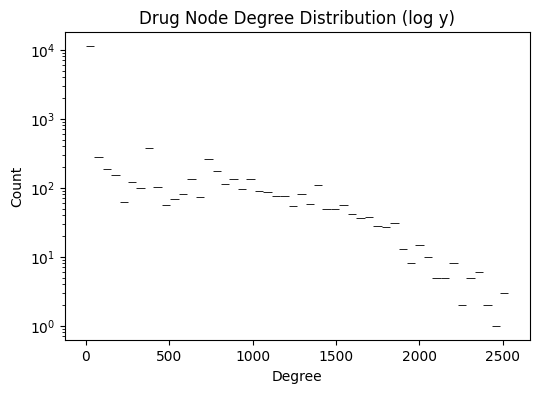

In [16]:
# Cell 8 — Graph Statistics Using PyG 

from torch_geometric.utils import degree

display(Markdown("## Basic Graph Statistics (PyG)"))

# Degree of drug nodes (considering all drug→protein and drug→drug edges)
deg_drug = torch.zeros(data['drug'].num_nodes, dtype=torch.long)

# accumulate degree from each relation
for rel in [('drug','targets','protein'),
            ('drug','enzymes','protein'),
            ('drug','transporters','protein'),
            ('drug','interacts','drug')]:

    edge_index = data[rel].edge_index
    for src in edge_index[0]:
        deg_drug[src] += 1

display(Markdown("### Drug Node Degree Stats"))
display(pd.DataFrame({
    "min_degree": [int(deg_drug.min())],
    "max_degree": [int(deg_drug.max())],
    "mean_degree": [float(deg_drug.float().mean())],
    "median_degree": [float(deg_drug.float().median())]
}))

plt.figure(figsize=(6,4))
sns.histplot(deg_drug.numpy(), bins=50, log_scale=(False, True))
plt.title("Drug Node Degree Distribution (log y)")
plt.xlabel("Degree")
plt.show()


In [17]:
# Cell 9 — Pairwise protein-overlap EDA

display(Markdown("## Pairwise EDA — Shared Proteins vs Known DDI"))

usable_drugs = [
    d for d in drug_ids 
    if (drug_to_targets.get(d) or drug_to_enzymes.get(d) or drug_to_transporters.get(d))
]

def shared_counts(d1, d2):
    return {
        "shared_targets": len(set(drug_to_targets.get(d1, [])) & set(drug_to_targets.get(d2, []))),
        "shared_enzymes": len(set(drug_to_enzymes.get(d1, [])) & set(drug_to_enzymes.get(d2, []))),
        "shared_transporters": len(set(drug_to_transporters.get(d1, [])) & set(drug_to_transporters.get(d2, []))),
        "shared_pathways": len(set(drug_to_pathways.get(d1, [])) & set(drug_to_pathways.get(d2, []))),
    }

known_pairs = {
    tuple(sorted([a,b]))
    for a,lst in drug_to_interactions.items()
    for b in lst
    if a in drug_index and b in drug_index
}

N_SAMPLE = 20000
sampled_pairs = set()
import random
random.seed(42)

drug_sample = usable_drugs[:4000] if len(usable_drugs)>4000 else usable_drugs
while len(sampled_pairs) < N_SAMPLE:
    a,b = random.sample(drug_sample, 2)
    sampled_pairs.add(tuple(sorted([a,b])))

rows = []
for a,b in sampled_pairs:
    feats = shared_counts(a,b)
    rows.append({
        "drug_a":a, "drug_b":b,
        "is_known":1 if (a,b) in known_pairs else 0,
        **feats
    })

pairdf = pd.DataFrame(rows)
pairdf.head()


## Pairwise EDA — Shared Proteins vs Known DDI

,drug_a,drug_b,is_known,shared_targets,shared_enzymes,shared_transporters,shared_pathways
0,DB03714,DB05016,0,0,0,0,0
1,DB02307,DB03834,0,0,0,0,0
2,DB01701,DB03912,0,0,0,0,0
3,DB02590,DB03779,0,0,0,0,0
4,DB01140,DB02410,0,0,0,0,0


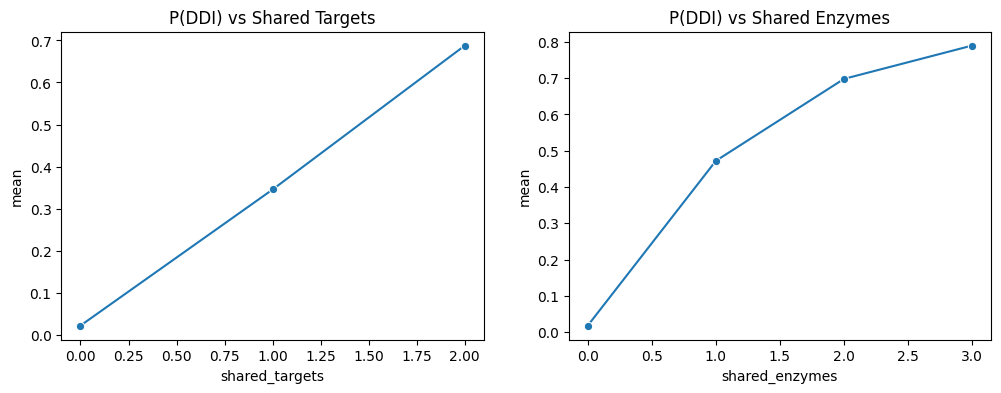

,shared_targets,shared_enzymes,shared_transporters,shared_pathways,is_known
shared_targets,1.000000,0.030781,0.015697,NaN,0.199026
shared_enzymes,0.030781,1.000000,0.072386,NaN,0.128554
shared_transporters,0.015697,0.072386,1.000000,NaN,0.150244
shared_pathways,NaN,NaN,NaN,NaN,NaN
is_known,0.199026,0.128554,0.150244,NaN,1.000000


In [18]:
# Cell 10 — Probability Plots & Correlations

def prob_by(x):
    g = pairdf.groupby(x)['is_known'].agg(['mean','count']).reset_index()
    return g[g['count']>10]

p1 = prob_by("shared_targets")
p2 = prob_by("shared_enzymes")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.lineplot(data=p1, x='shared_targets', y='mean', marker='o')
plt.title("P(DDI) vs Shared Targets")

plt.subplot(1,2,2)
sns.lineplot(data=p2, x='shared_enzymes', y='mean', marker='o')
plt.title("P(DDI) vs Shared Enzymes")

plt.show()

pairdf[["shared_targets","shared_enzymes","shared_transporters","shared_pathways","is_known"]].corr()


In [ ]:
# Cell 11: Save artifacts and show PyG snippet
if 'df' in globals():
    display(Markdown("If you want to persist node/edge lists for modeling, use the snippet below (uncomment to run)"))
    print(r"""
# Example saving snippet (uncomment to run)
# drug_index = {d:i for i,d in enumerate(sorted([n for n,a in G.nodes(data=True) if a.get('ntype')=='drug']))}
# prot_index = {p:i for i,p in enumerate(sorted([n for n,a in G.nodes(data=True) if a.get('ntype')!='drug']))}
# drug_target_edges = [(drug_index[u], prot_index[v]) for u,v,a in G.edges(data=True) if a.get('etype')=='target']
# ddi_edges = [(drug_index[a], drug_index[b]) for a,b in known_pairs if a in drug_index and b in drug_index]
# pd.DataFrame(drug_target_edges, columns=['drug_idx','prot_idx']).to_csv('drug_target_edges.csv', index=False)
# pd.DataFrame(ddi_edges, columns=['drug_a','drug_b']).to_csv('ddi_edges.csv', index=False)
""")
    display(Markdown("PyG HeteroData example (requires torch + torch_geometric):"))
    print(r"""
# from torch_geometric.data import HeteroData
# data = HeteroData()
# data['drug'].num_nodes = len(drug_index)
# data['protein'].num_nodes = len(prot_index)
# data['drug','targets','protein'].edge_index = torch.tensor(list(zip(*drug_target_edges)), dtype=torch.long)
# data['drug','interacts','drug'].edge_index = torch.tensor(list(zip(*ddi_edges)), dtype=torch.long)
# torch.save(data, 'drugbank_heterodata.pt')
""")


If you want to persist node/edge lists for modeling, use the snippet below (uncomment to run)


# Example saving snippet (uncomment to run)
# drug_index = {d:i for i,d in enumerate(sorted([n for n,a in G.nodes(data=True) if a.get('ntype')=='drug']))}
# prot_index = {p:i for i,p in enumerate(sorted([n for n,a in G.nodes(data=True) if a.get('ntype')!='drug']))}
# drug_target_edges = [(drug_index[u], prot_index[v]) for u,v,a in G.edges(data=True) if a.get('etype')=='target']
# ddi_edges = [(drug_index[a], drug_index[b]) for a,b in known_pairs if a in drug_index and b in drug_index]
# pd.DataFrame(drug_target_edges, columns=['drug_idx','prot_idx']).to_csv('drug_target_edges.csv', index=False)
# pd.DataFrame(ddi_edges, columns=['drug_a','drug_b']).to_csv('ddi_edges.csv', index=False)



PyG HeteroData example (requires torch + torch_geometric):


# from torch_geometric.data import HeteroData
# data = HeteroData()
# data['drug'].num_nodes = len(drug_index)
# data['protein'].num_nodes = len(prot_index)
# data['drug','targets','protein'].edge_index = torch.tensor(list(zip(*drug_target_edges)), dtype=torch.long)
# data['drug','interacts','drug'].edge_index = torch.tensor(list(zip(*ddi_edges)), dtype=torch.long)
# torch.save(data, 'drugbank_heterodata.pt')

